Transaction Data Columns: ['Transaction_ID', 'Customer_ID', 'Transaction_Date', 'Transaction_Amount', 'Transaction_Type']
   Transaction_ID  Customer_ID     Transaction_Date  Transaction_Amount  \
0               1          393  2023-01-01 00:00:00              3472.0   
1               2          826  2023-01-01 01:00:00                 NaN   
2               3          916  2023-01-01 02:00:00                10.0   
3               4          109  2023-01-01 03:00:00                72.0   
4               5          889  2023-01-01 04:00:00              1793.0   

  Transaction_Type  
0         Purchase  
1     Bill Payment  
2         Purchase  
3       Investment  
4       Investment  


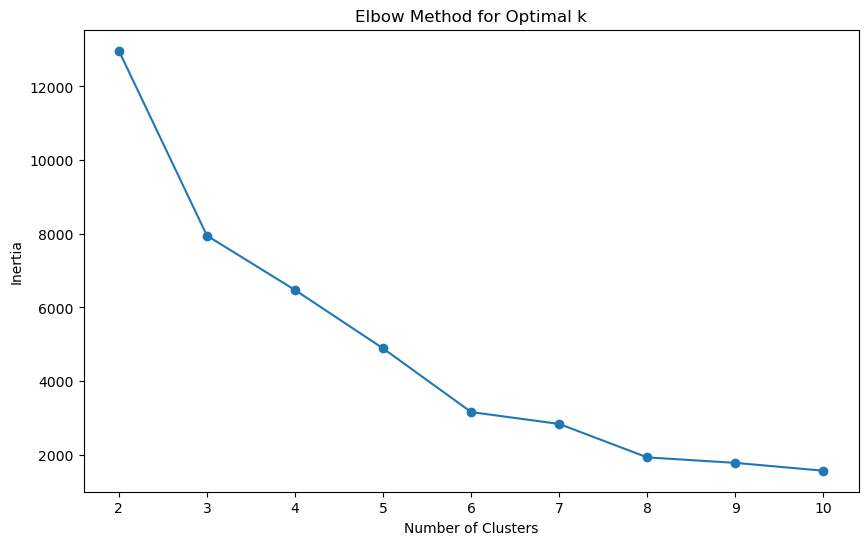

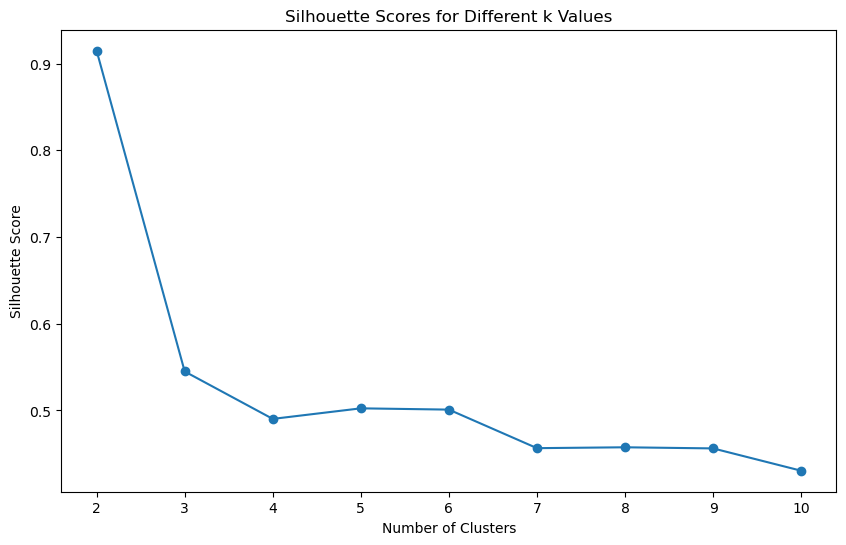

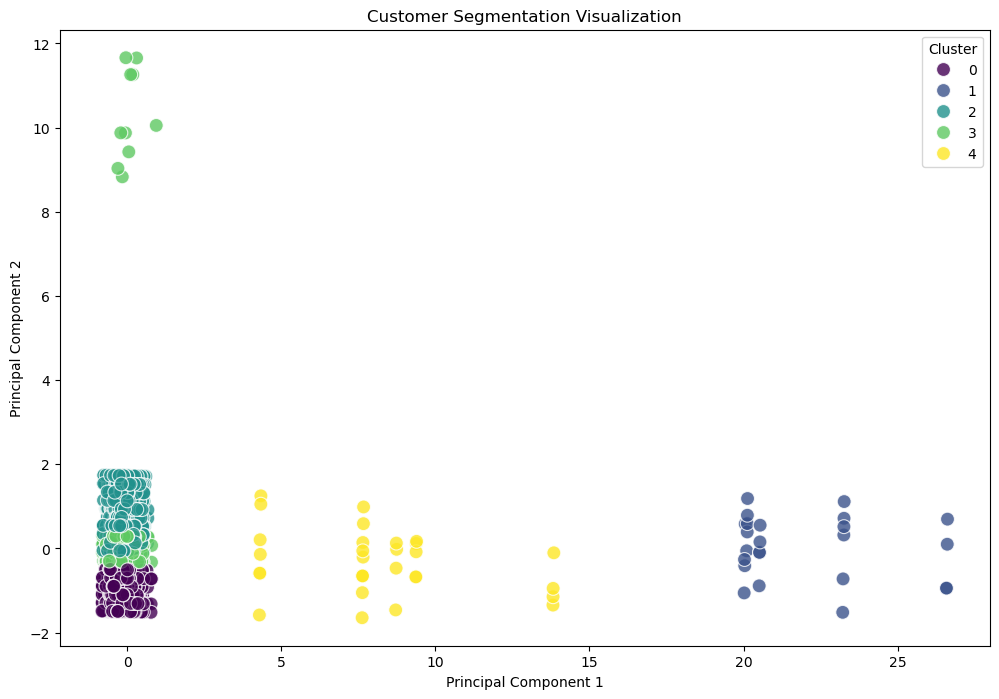

Cluster Profiles:


Cluster Satisfaction_Score    Total_Spend                CLV_Score
                        mean           mean    median           mean
0       0           3.705107   12364.466814   11596.0    8656.239491
1       1           6.416667  438845.208333  432432.0  307193.570833
2       2           5.600608   12339.919857   11538.0    8639.624298
3       3           8.842631   12286.217100   11640.0    8603.004191
4       4           5.451613  191472.548387  198050.0  134032.419355


Actionable Recommendations:
Cluster 0: Focus on loyalty programs for high-spending satisfied customers
Cluster 1: Improve product education for low-satisfaction customers
Cluster 2: Target medium-spending customers with cross-sell opportunities
Cluster 3: Develop retention strategies for at-risk low-spending customers
Cluster 4: Create personalized offers for high-potential new customers


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load all datasets
customer_feedback = pd.read_csv('Customer_Feedback_Data.csv')
transaction_data = pd.read_csv('Transaction_Data.csv')

# Inspect transaction data
print("Transaction Data Columns:", transaction_data.columns.tolist())
print(transaction_data.head())  # Display first few rows

# Convert Transaction Date
transaction_data['Transaction_Date'] = pd.to_datetime(
    transaction_data['Transaction_Date']
)

# Aggregate transaction data by Customer_ID
customer_products = transaction_data.groupby('Customer_ID').agg({
    'Transaction_Amount': ['sum', 'mean'],
}).reset_index()
customer_products.columns = ['Customer_ID', 'Total_Spend', 'Avg_Transaction']

# Merge with Customer Feedback
full_data = customer_feedback.merge(
    customer_products,
    on='Customer_ID',
    how='left'
)

# Handle missing values in Customer Feedback using .loc to avoid chained assignment warning
full_data['Satisfaction_Score'] = pd.to_numeric(
    full_data['Satisfaction_Score'], errors='coerce'
)
full_data.loc[full_data['Satisfaction_Score'].isna(), 'Satisfaction_Score'] = full_data['Satisfaction_Score'].median()
full_data.loc[full_data['Feedback_Comments'].isna(), 'Feedback_Comments'] = ''

# Create feedback sentiment feature
full_data['Feedback_Sentiment'] = full_data['Feedback_Comments'].apply(
    lambda x: 1 if 'good' in str(x).lower() or 'excellent' in str(x).lower() else -1
)

# Create customer lifetime value proxy (CLV)
full_data['CLV_Score'] = (full_data['Total_Spend'] * 0.7) + (full_data['Satisfaction_Score'] * 0.3)

# Select features for clustering
clustering_features = ['Satisfaction_Score', 'Total_Spend', 'Avg_Transaction', 'CLV_Score', 'Feedback_Sentiment']

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_data[clustering_features].fillna(0))

# Elbow Method to find optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2,11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette Analysis to validate clustering quality
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

optimal_clusters = 5  # Set based on elbow/silhouette results
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
full_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Step 8: Cluster Visualization using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x=principal_components[:,0],
    y=principal_components[:,1],
    hue=full_data['Cluster'],
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Customer Segmentation Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

cluster_profile = full_data.groupby('Cluster').agg({
    'Satisfaction_Score': 'mean',
    'Total_Spend': ['mean', 'median'],
    'CLV_Score': 'mean',
}).reset_index()

print("Cluster Profiles:")
display(cluster_profile)

recommendations = {
    0: "Focus on loyalty programs for high-spending satisfied customers",
    1: "Improve product education for low-satisfaction customers",
    2: "Target medium-spending customers with cross-sell opportunities",
    3: "Develop retention strategies for at-risk low-spending customers",
    4: "Create personalized offers for high-potential new customers"
}

print("\nActionable Recommendations:")
for cluster, rec in recommendations.items():
    print(f"Cluster {cluster}: {rec}")


# Clustering and Segmentation Approach

## Introduction
In our analysis, we utilized clustering and segmentation techniques to better understand customer behavior and tailor our marketing strategies. This approach allows us to group customers based on shared characteristics, leading to more personalized interactions.

## Why Clustering and Segmentation?

1. **Understanding Customer Behavior**:
   - Clustering helps us identify patterns in customer behavior, such as spending habits, satisfaction levels, and product preferences.

2. **Personalized Marketing**:
   - By segmenting customers into distinct groups, we can tailor our marketing strategies to meet the specific needs of each group. For instance, high-value customers may receive loyalty rewards, while low-satisfaction customers may require targeted retention efforts.

3. **Improved Decision-Making**:
   - Segmentation provides actionable insights that help us allocate resources effectively. Identifying at-risk customers allows us to focus on retention strategies.

4. **Data-Driven Insights**:
   - Clustering provides a data-driven way to group customers without relying on predefined categories, ensuring that the segmentation reflects actual patterns in the data.

## How the Clustering and Segmentation Works

### 1. Data Preparation
We began by cleaning and preprocessing the data to ensure it was suitable for clustering:
- Handled missing values by filling them with appropriate statistics (e.g., median for satisfaction scores).
- Normalized numerical features to ensure equal contribution to clustering.

### 2. Feature Selection
The following features were chosen for clustering:
- **Satisfaction_Score**: Measures customer satisfaction.
- **Total_Spend**: Captures overall spending behavior.
- **Avg_Transaction**: Reflects average transaction size.
- **CLV_Score**: Combines spending and satisfaction to estimate customer lifetime value.
- **Feedback_Sentiment**: Indicates whether the customer's feedback is positive or negative.

### 3. Scaling Features
To ensure that all features contribute equally to clustering, we standardized the features using `StandardScaler`.

### 4. Elbow Method
The Elbow Method was used to determine the optimal number of clusters (`k`) by plotting inertia (sum of squared distances within clusters) against different values of `k`. The "elbow point" indicates where adding more clusters provides diminishing returns in reducing inertia.

### 5. Silhouette Analysis
Silhouette scores were calculated to measure how well-separated the clusters were. Higher silhouette scores indicate better-defined clusters.

### 6. Clustering with K-Means
K-Means was employed for clustering due to its efficiency with numerical data. Customers were assigned to clusters based on their proximity to cluster centroids.

### 7. Dimensionality Reduction for Visualization
Principal Component Analysis (PCA) was used to reduce high-dimensional data into two principal components for visualization, allowing us to inspect how well-separated the clusters are.

### 8. Cluster Profiling
After clustering, each cluster was analyzed to understand its characteristics:
- Average satisfaction score
- Spending behavior (total spend, average transaction)
- Feedback sentiment
- Customer lifetime value (CLV)

## Interpretation of Results

1. **Cluster 0: High-Spending Satisfied Customers**
   - High satisfaction scores and high total spend.
   - **Action**: Focus on loyalty programs to retain these valuable customers.

2. **Cluster 1: Low-Satisfaction Customers**
   - Low satisfaction scores despite moderate spending.
   - **Action**: Improve product education or service quality for these customers.

3. **Cluster 2: Medium-Spending Customers**
   - Moderate spending with potential for growth.
   - **Action**: Target these customers with cross-sell opportunities (e.g., additional products).

4. **Cluster 3: At-Risk Customers**
   - Low spending and low satisfaction scores.
   - **Action**: Develop retention strategies to prevent churn.

5. **Cluster 4: High-Potential New Customers**
   - High CLV scores but lower current spending.
   - **Action**: Create personalized offers to encourage higher engagement.

## Conclusion
This clustering and segmentation approach provides a systematic way to analyze customer data and derive actionable insights. By grouping customers based on their behavior and characteristics, we can optimize our strategies for retention, acquisition, and cross-selling opportunities.
